# Universidad Autonoma de Aguascalientes

- ### Departamento: Ciencias de la computacion
- ### Carrera: Ingenieria en Computacion Inteligente
- ### Curso: Metaheuristicas I
- ### Maestro: Dr Francisco Javier Luna Rosas
- ### Alumnos: Jose Carlos Macias Macias, Sebastían Herrera Murillo, Guillermo Gonzales Lara, Luis Angel Flores Escobedo
- ### Fecha: 02/10/2024

## Actividad 3

El alumno deberá analizar e implementar el método Algoritmo Genetico para la Planificación
de Carga de 100000 Criticas de Cine. El alumno deberá tomar
como base el articulo denominado: Observations on Using Genetic Algorithms for Dynamic
Load-Balancing.pdf.
La planificación deberá utilizar **n** procesadores homogéneos para: 10000, 20000,
30000, 40000, 50000, 60000, 70000, 80000, 90000 y 100000 criticas de cine

La planificación de tareas se hará de manera simulada, poniendo un tiempo de procesamiento por critica.

## Importar Librerias


In [22]:
! pip install deap
from deap import base, creator, tools
import random
import numpy as np
import matplotlib.pyplot as plt

### Definición de numero de procesadores para el algoritmo

In [23]:
NUM_REVIEWS_LIST = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
NUM_PROCESADORES = 8

### Creación del algoritmo Genetico con DEAP

In [24]:
# 1. Definir la clase de aptitud y de individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Configurar la caja de herramientas
toolbox = base.Toolbox()
toolbox.register("attr_bit", random.randint, 0, 1)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

### Funcion para decodificar de binario a entero para asignar las cargas

In [25]:
# Función para decodificar un individuo de binario a procesadores
def decode_individual(individual):
    """Convierte los bits del cromosoma en asignaciones de procesador para cada crítica."""
    assignments = []
    for i in range(0, len(individual), 3):
        # Cada 3 bits forman un número binario (0 a 7 para los 8 procesadores)
        processor = individual[i] * 4 + individual[i+1] * 2 + individual[i+2]
        processor %= NUM_PROCESADORES  # Asegurarse de que el procesador esté en el rango válido
        assignments.append(processor)
    return assignments

### Definición de función de fitness

In [26]:
def evaluate(individual):
    # Inicializar un array para las cargas de cada procesador
    processor_assignments = decode_individual(individual)

    processor_loads = np.zeros(NUM_PROCESADORES, dtype=int)

    # Asignar las cargas a cada procesador según el cromosoma
    for review, processor in enumerate(processor_assignments):
        processor_loads[processor] += DURACION_POR_REVIEW[review]

    # Calcular maxspan (la carga máxima entre los procesadores)
    maxspan = np.max(processor_loads)

    # Calculando el uso promedio de los procesadores
    total_load = np.sum(processor_loads)
    average_utilization = total_load / NUM_PROCESADORES if NUM_PROCESADORES > 0 else 0

    # Calcular el número de "colas aceptables"
    threshold = 0.8 * maxspan
    num_acceptable_queues = sum(1 for load in processor_loads if load <= threshold)

    if maxspan > 0:
        fitness_value = (1 / maxspan) * average_utilization * (num_acceptable_queues / NUM_PROCESADORES)
    else:
        fitness_value = 0

    # Retornar el fitness como una tupla (obligatorio para DEAP)
    return fitness_value,

toolbox.register("evaluate", evaluate)


### Algoritmo Genetico

In [27]:
def algoritmoGenetico(num_reviews):
    global DURACION_POR_REVIEW
    DURACION_POR_REVIEW = [random.randint(1, 10) for _ in range(num_reviews)] # Damos un valor de procesamiento por cada critica de cine.

    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bit, n=num_reviews * 3)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    population = toolbox.population(n=50)
    NUM_GENERACIONES = 30
    PROB_CRUZAMIENTO, PROB_MUTACION = 0.7, 0.1

    for gen in range(NUM_GENERACIONES):
        # Seleccionamos todos los
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Aplicar cruzamiento y mutación
        for child1, child2 in zip(offspring[::2], offspring[1::2]): # Los agrupa en parejas de pares e impares
            if random.random() < PROB_CRUZAMIENTO:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < PROB_MUTACION:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluar la descendencia
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Reemplazar la población
        population[:] = offspring

    best_ind = tools.selBest(population, 1)[0]
    best_assignment = decode_individual(best_ind)
    processor_loads = [sum(DURACION_POR_REVIEW[i] for i in range(num_reviews) if best_assignment[i] == p) for p in range(NUM_PROCESADORES)]
    maxspan = min(processor_loads)

    print(f"\nResultados para {num_reviews} críticas:")
    print("Mejor distribución de críticas:", best_ind)
    print("Cargas por procesador:", processor_loads)
    print("Maxspan mínimo:", maxspan)

    return maxspan

### Ejecución de algoritmo

In [28]:
resultados = []

for num_reviews in NUM_REVIEWS_LIST:
	print(f"Ejecutando para {num_reviews} críticas...")
	maxspan = algoritmoGenetico(num_reviews)
	tiempo_secuencial = num_reviews
	tiempo_paralelo = maxspan
	resultados.append((num_reviews, tiempo_secuencial, tiempo_paralelo))

# Mostrar resultados en una tabla
print("\nResultados:")
print("Número de Críticas | Tiempo Secuencial | Tiempo Paralelo")
for res in resultados:
    print(f"{res[0]:<18} | {res[1]:<16} | {res[2]:<14}")



Ejecutando para 10000 críticas...

Resultados para 10000 críticas:
Mejor distribución de críticas: [1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 

## Grafica de comparación

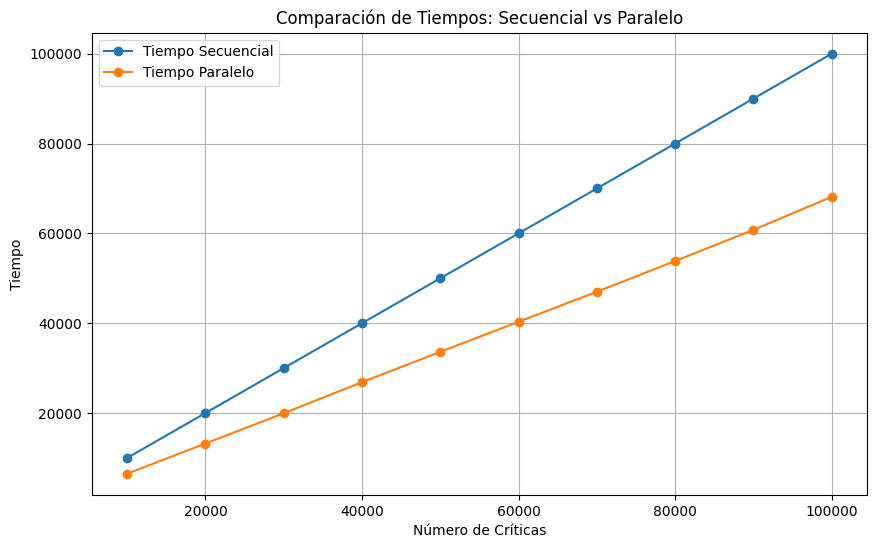

In [30]:
num_reviews, tiempos_secuenciales, tiempos_paralelos = zip(*resultados)
plt.figure(figsize=(10, 6))
plt.plot(num_reviews, tiempos_secuenciales, label="Tiempo Secuencial", marker='o')
plt.plot(num_reviews, tiempos_paralelos, label="Tiempo Paralelo", marker='o')
plt.xlabel("Número de Críticas")
plt.ylabel("Tiempo")
plt.title("Comparación de Tiempos: Secuencial vs Paralelo")
plt.legend()
plt.grid(True)
plt.show()

### Conclusión

Al realizar el algoritmo genetico con la libreria Deap, fue facil implementarlo con sus debidas modificaciones para adaptarlo a un problema de asignación de cargas.
El codigo pudiera ser modificado con mayor capacidad para una ejecución mas rapida, pero en si, nos da buenos resultados para resultar en una carga balanceada para las tareas dadas.



### Referencias

- A. Y. Zomaya and Yee-Hwei Teh, "Observations on using genetic algorithms for dynamic load-balancing," in IEEE Transactions on Parallel and Distributed Systems, vol. 12, no. 9, pp. 899-911, Sept. 2001, doi: 10.1109/71.954620.
 https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=954620&isnumber=20644

